In [3]:
from datasets import load_dataset

# Load training data
train_dataset = load_dataset("wmt16", "de-en", split="train")

# Load validation data
validation_dataset = load_dataset("wmt16", "de-en", split="validation")

# Load test data
test_dataset = load_dataset("wmt16", "de-en", split="test")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4548885 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2999 [00:00<?, ? examples/s]

In [5]:
len(train_dataset)

4548885

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
# Load training data with IDs
from datasets import load_dataset, DatasetDict

train_dataset[0]['translation']
print(train_dataset.shape)

{'de': 'Wiederaufnahme der Sitzungsperiode', 'en': 'Resumption of the session'}

{'de': 'Wiederaufnahme der Sitzungsperiode', 'en': 'Resumption of the session'}

In [ ]:
from transformers import AutoTokenizer

checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
source_lang = "de"
target_lang = "en"
prefix = "translate German to English: "


def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

In [ ]:
german_data = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

In [ ]:
tokenized_books = german_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/2169 [00:00<?, ? examples/s]

Map:   0%|          | 0/2169 [00:00<?, ? examples/s]

Map:   0%|          | 0/2999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2999 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [ ]:
import evaluate

metric = evaluate.load("sacrebleu")

In [ ]:
import numpy as np


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="jeri",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_books["train"],
    eval_dataset=tokenized_books["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,No log,2.792130,1.055100,17.396000
2,No log,2.742366,1.050300,17.391400
3,No log,2.715669,1.047800,17.378500
4,No log,2.696521,1.044300,17.360100
5,No log,2.688502,1.041800,17.357800


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,No log,2.792130,1.055100,17.396000
2,No log,2.742366,1.050300,17.391400
3,No log,2.715669,1.047800,17.378500
4,No log,2.696521,1.044300,17.360100
5,No log,2.688502,1.041800,17.357800


TrainOutput(global_step=35, training_loss=3.188857160295759, metrics={'train_runtime': 179.3456, 'train_samples_per_second': 2.788, 'train_steps_per_second': 0.195, 'total_flos': 14568276099072.0, 'train_loss': 3.188857160295759, 'epoch': 5.0})

TrainOutput(global_step=35, training_loss=3.188857160295759, metrics={'train_runtime': 179.3456, 'train_samples_per_second': 2.788, 'train_steps_per_second': 0.195, 'total_flos': 14568276099072.0, 'train_loss': 3.188857160295759, 'epoch': 5.0})

In [ ]:
 # Function to generate translations

def generate_translation(batch):
    inputs = tokenizer(["translate German to English" + entry['de'] for entry in batch['translation']], return_tensors='pt', padding=True)
    inputs = inputs.to("cuda")
    outputs = model.generate(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], do_sample=False)
    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return {"translations": preds}

  # Generate translations for validation set
validation_results = validation_dataset.map(generate_translation, batched=True, batch_size=4)

  # Generate translations for test set
test_results = test_dataset.map(generate_translation, batched=True, batch_size=4)

Map:   0%|          | 0/2169 [00:00<?, ? examples/s]

Map:   0%|          | 0/2169 [00:00<?, ? examples/s]

Map:   0%|          | 0/2999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2999 [00:00<?, ? examples/s]

In [ ]:
preds_val = [ex['translations'] for ex in validation_results]
references_val = [ex['translation']['en'] for ex in validation_results]

preds_test = [ex['translations'] for ex in test_results]
references_test = [ex['translation']['en'] for ex in test_results]

In [ ]:
# Calculate evaluation metrics
import evaluate

metric1 = evaluate.load('bleu')

In [ ]:
score_val_1 = metric1.compute(predictions=preds_val, references=references_val, max_order=1)
score_test_1 = metric1.compute(predictions=preds_test, references=references_test, max_order=1)

In [ ]:
print(score_val_1)
print(score_test_1)

{'bleu': 0.04409252491562662, 'precisions': [0.14046014408552174], 'brevity_penalty': 0.3139148489608559, 'length_ratio': 0.46325603427857803, 'translation_length': 21515, 'reference_length': 46443}
{'bleu': 0.04989272626607919, 'precisions': [0.1489827242741909], 'brevity_penalty': 0.33488934041946755, 'length_ratio': 0.47756515229495156, 'translation_length': 30621, 'reference_length': 64119}
{'bleu': 0.04409252491562662, 'precisions': [0.14046014408552174], 'brevity_penalty': 0.3139148489608559, 'length_ratio': 0.46325603427857803, 'translation_length': 21515, 'reference_length': 46443}
{'bleu': 0.04989272626607919, 'precisions': [0.1489827242741909], 'brevity_penalty': 0.33488934041946755, 'length_ratio': 0.47756515229495156, 'translation_length': 30621, 'reference_length': 64119}


In [ ]:
score_val = metric1.compute(predictions=preds_val, references=references_val, max_order=2)
score_test = metric1.compute(predictions=preds_test, references=references_test, max_order=2)
print(score_val)
print(score_test)

{'bleu': 0.01950870885523332, 'precisions': [0.14046014408552174, 0.027496677910661353], 'brevity_penalty': 0.3139148489608559, 'length_ratio': 0.46325603427857803, 'translation_length': 21515, 'reference_length': 46443}
{'bleu': 0.02312082514284476, 'precisions': [0.1489827242741909, 0.03199396746741355], 'brevity_penalty': 0.33488934041946755, 'length_ratio': 0.47756515229495156, 'translation_length': 30621, 'reference_length': 64119}
{'bleu': 0.01950870885523332, 'precisions': [0.14046014408552174, 0.027496677910661353], 'brevity_penalty': 0.3139148489608559, 'length_ratio': 0.46325603427857803, 'translation_length': 21515, 'reference_length': 46443}
{'bleu': 0.02312082514284476, 'precisions': [0.1489827242741909, 0.03199396746741355], 'brevity_penalty': 0.33488934041946755, 'length_ratio': 0.47756515229495156, 'translation_length': 30621, 'reference_length': 64119}


In [ ]:
score_val = metric1.compute(predictions=preds_val, references=references_val, max_order=3)
score_test = metric1.compute(predictions=preds_test, references=references_test, max_order=3)
print(score_val)
print(score_test)

{'bleu': 0.011086095497158202, 'precisions': [0.14046014408552174, 0.027496677910661353, 0.011404255319148937], 'brevity_penalty': 0.3139148489608559, 'length_ratio': 0.46325603427857803, 'translation_length': 21515, 'reference_length': 46443}
{'bleu': 0.012535787850029515, 'precisions': [0.1489827242741909, 0.03199396746741355, 0.011003907184435053], 'brevity_penalty': 0.33488934041946755, 'length_ratio': 0.47756515229495156, 'translation_length': 30621, 'reference_length': 64119}
{'bleu': 0.011086095497158202, 'precisions': [0.14046014408552174, 0.027496677910661353, 0.011404255319148937], 'brevity_penalty': 0.3139148489608559, 'length_ratio': 0.46325603427857803, 'translation_length': 21515, 'reference_length': 46443}
{'bleu': 0.012535787850029515, 'precisions': [0.1489827242741909, 0.03199396746741355, 0.011003907184435053], 'brevity_penalty': 0.33488934041946755, 'length_ratio': 0.47756515229495156, 'translation_length': 30621, 'reference_length': 64119}


In [ ]:
score_val = metric1.compute(predictions=preds_val, references=references_val, max_order=4)
score_test = metric1.compute(predictions=preds_test, references=references_test, max_order=4)
print(score_val)
print(score_test)

{'bleu': 0.006833991730937409, 'precisions': [0.14046014408552174, 0.027496677910661353, 0.011404255319148937, 0.0050997641359087145], 'brevity_penalty': 0.3139148489608559, 'length_ratio': 0.46325603427857803, 'translation_length': 21515, 'reference_length': 46443}
{'bleu': 0.0073550230253782425, 'precisions': [0.1489827242741909, 0.03199396746741355, 0.011003907184435053, 0.004435881351375571], 'brevity_penalty': 0.33488934041946755, 'length_ratio': 0.47756515229495156, 'translation_length': 30621, 'reference_length': 64119}
{'bleu': 0.006833991730937409, 'precisions': [0.14046014408552174, 0.027496677910661353, 0.011404255319148937, 0.0050997641359087145], 'brevity_penalty': 0.3139148489608559, 'length_ratio': 0.46325603427857803, 'translation_length': 21515, 'reference_length': 46443}
{'bleu': 0.0073550230253782425, 'precisions': [0.1489827242741909, 0.03199396746741355, 0.011003907184435053, 0.004435881351375571], 'brevity_penalty': 0.33488934041946755, 'length_ratio': 0.477565152

In [ ]:
#make a function which will calculate the BERTScore
def calculate_bert_score(preds, refs):
    from bert_score import score
    P, R, F1 = score(preds, refs, lang='de', verbose=True)
    return {"P": P.mean().item(), "R": R.mean().item(), "F1": F1.mean().item()}

# Calculate BERTScore
bert_score_val = calculate_bert_score(preds_val, references_val)
bert_score_test = calculate_bert_score(preds_test, references_test)

print(bert_score_val)
print(bert_score_test)

calculating scores...
computing bert embedding.


  0%|          | 0/64 [00:00<?, ?it/s]

calculating scores...
computing bert embedding.


  0%|          | 0/64 [00:00<?, ?it/s]

computing greedy matching.
computing greedy matching.


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

done in 7.06 seconds, 307.30 sentences/sec
done in 7.06 seconds, 307.30 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/89 [00:00<?, ?it/s]

calculating scores...
computing bert embedding.


  0%|          | 0/89 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/47 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/47 [00:00<?, ?it/s]

done in 8.93 seconds, 335.93 sentences/sec
{'P': 0.6511473655700684, 'R': 0.6228175163269043, 'F1': 0.63607257604599}
{'P': 0.6728425025939941, 'R': 0.6443879008293152, 'F1': 0.6577196717262268}


done in 8.93 seconds, 335.93 sentences/sec
{'P': 0.6511473655700684, 'R': 0.6228175163269043, 'F1': 0.63607257604599}
{'P': 0.6728425025939941, 'R': 0.6443879008293152, 'F1': 0.6577196717262268}


In [ ]:
lst = list(trainer.state.log_history)

In [ ]:
lst[0]['eval_loss']

2.7921295166015625

2.7921295166015625

In [ ]:
len(lst)

6

6

In [ ]:
loss=[]
for i in range(len(lst)):
    loss.append(lst[0]['eval_loss'])

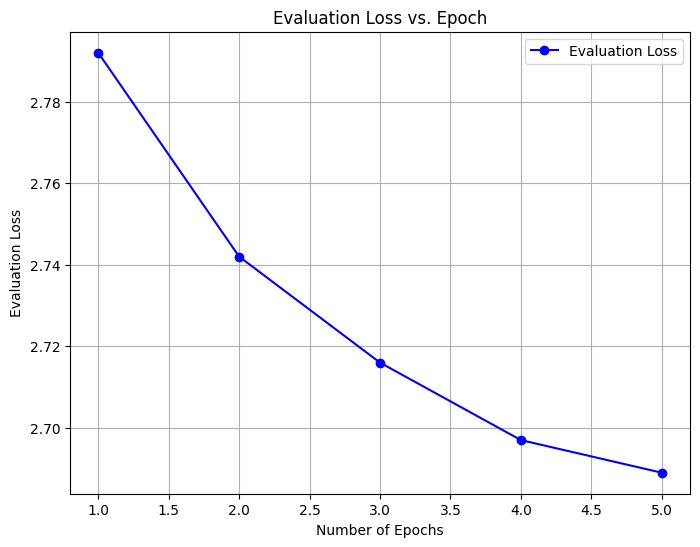

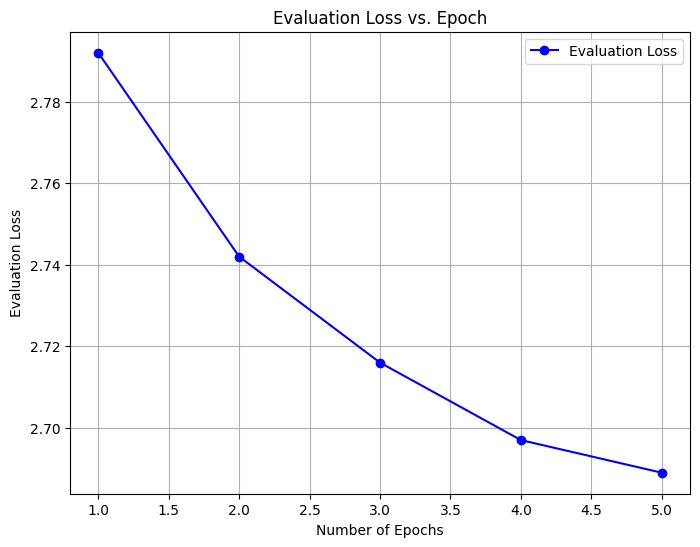

In [ ]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
epochs = [1, 2, 3, 4, 5]
eval_loss = [2.792, 2.742, 2.716, 2.697, 2.689]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, eval_loss, marker='o', color='b', label='Evaluation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Evaluation Loss')
plt.title('Evaluation Loss vs. Epoch')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import torch
model = torch.load()